# <center> Foundations of Geometric Methods in Data Analysis </center>
# <center> Project 10: Geodesic filtrations for segmentation </center>
## <center> DARGIER Antoine - RAMAMONJY Johary </center>
### <center> May 5, 2023 </center>

The purpose of this project is to implement geodesic filtrations that can be used to classify points on 3D
shapes, which is also called the segmentation problem. For this, 3D shapes will be filtered locally by using
geodesic distances to basepoints in order to generate signatures that are invariant to solid transformations.
The project is based on the content of this article: http://www.lix.polytechnique.fr/Labo/Ovsjanikov.Maks/papers/perslocsig.pdf, published in 2015 and written by Mathieu Carrière, Steve Y. Oudot and Maks Ovsjanikov.

# Table of contents:

* [0. Requirements](#chapter0)
* [1. Utils functions to read files](#chapter1)
* [2. Geodesic distances](#chapter2)
    * [2.1 Graph computation](#section_2_1)
    * [2.2 Geodesic distances computation](#section_2_2)
    * [2.3 Outputs](#section_2_3)
* [3. Point signatures](#chapter3)
* [4. Stability theorem](#chapter4)
    * [4.1 Stability between two shapes](#section_4_1)
    * [4.2 Stability for two close basepoints](#section_4_2)
* [5. Statistical tests](#chapter5)
* [6. Segmentation problem](#chapter6)

# 0. Requirements <a class="anchor" id="chapter0"></a>

In [1]:
import gudhi
import gudhi.representations as gdr
import numpy as np
import heapq
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import sklearn.neighbors as skn
import sklearn.model_selection as skm
import sklearn.pipeline as skl
import sklearn.svm as sks
import sklearn.ensemble as ske
from termcolor import colored

# 1. Utils functions to read files <a class="anchor" id="chapter1"></a>

In [2]:
def off2numpy(shape_name):
    '''
    input: a off file called shape_name
    outputs: arrays with vertices and faces
    '''
    with open(shape_name, 'r') as S:
        S.readline()
        num_vertices, num_faces, _ = [int(n) for n in S.readline().split(' ')]
        info = S.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces    = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces

In [3]:
def get_labels(label_name, num_faces):
    '''
    inputs: text file label_name, number of faces
    output: array of label for each face
    '''
    L = np.empty([num_faces], dtype='|S100')
    with open(label_name, 'r') as S:
        info = S.readlines()
    labels, face_indices = info[0::2], info[1::2]
    for ilab, lab in enumerate(labels):
        indices = [int(f)-1 for f in face_indices[ilab].split(' ')[:-1]]
        L[np.array(indices)] = lab[:-1]
    return L

In [4]:
def face2points(vals_faces, faces, num_vertices):
    '''
    inputs: values for faces, faces, number of vertices
    output: array of labels for each vertex
    '''
    vals_points = np.empty([num_vertices], dtype=type(vals_faces))
    for iface, face in enumerate(faces):
        vals_points[face] = vals_faces[iface]
    return vals_points

# 2. Geodesic distances <a class="anchor" id="chapter2"></a>

## 2.1 Graph computation <a class="anchor" id="section_2_1"></a>

We create a graph from the vertices and faces, which can be then used to compute the geodesic distances. We create edges between vertices of the same faces, assiging as weights the euclidean distance between the nodes.

In [5]:
def create_mesh_graph(vertices, faces):
    """Create a graph from the vertices and faces of a triangular mesh."""
    graph = {}
    for face in faces:
        for i, vertex in enumerate(face):
            if vertex not in graph:
                graph[vertex] = {}
            next_vertex = face[(i + 1) % len(face)]
            if next_vertex not in graph:
                graph[next_vertex] = {}
            edge_length = ((vertices[next_vertex] - vertices[vertex]) ** 2).sum() ** 0.5
            graph[vertex][next_vertex] = edge_length
            graph[next_vertex][vertex] = edge_length
    return graph

## 2.2 Graph computation <a class="anchor" id="section_2_2"></a>

From the graph, we use the Dijkstra algorithm to compute the shortest path between the source node and all other points, returning it as dictionary.

In [6]:
def approx_geodesic_distances(graph, source):
    """Compute the shortest paths from the start node to all other nodes in the graph
    Compute the geodesic distances between the source node and all vertices"""
    distances = {vertex: float('inf') for vertex in graph}
    distances[source] = 0
    queue = [(0, source)]
    while queue:
        current_distance, current_vertex = heapq.heappop(queue)
        if current_distance > distances[current_vertex]:
            continue
        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(queue, (distance, neighbor))
    return distances

## 2.3 Outputs <a class="anchor" id="section_2_3"></a>

In [7]:
def print_figure_labels_distances(basepoint, vertices, faces, label_faces):
    '''
    print figure with labels, and figure with distances from basepoint side by side
    '''
    graph = create_mesh_graph(vertices, faces)
    distances = approx_geodesic_distances(graph, basepoint)
    sorted_distances = dict(sorted(distances.items()))
    list_distances = list(sorted_distances.values())
    fig = plt.figure()
    fig.set_size_inches(10, 8)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax1.set_title('Shapes segmentation')
    ax2.set_title('Geodesci distances from black basepoint')
    ax1.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, c=skp.LabelEncoder().fit_transform(face2points(label_faces, faces, len(vertices))))
    ax2.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, c=list_distances, cmap = 'jet')
    ax2.scatter(vertices[basepoint,0], vertices[basepoint,1], vertices[basepoint,2], s= 100, c="black")
    plt.show()

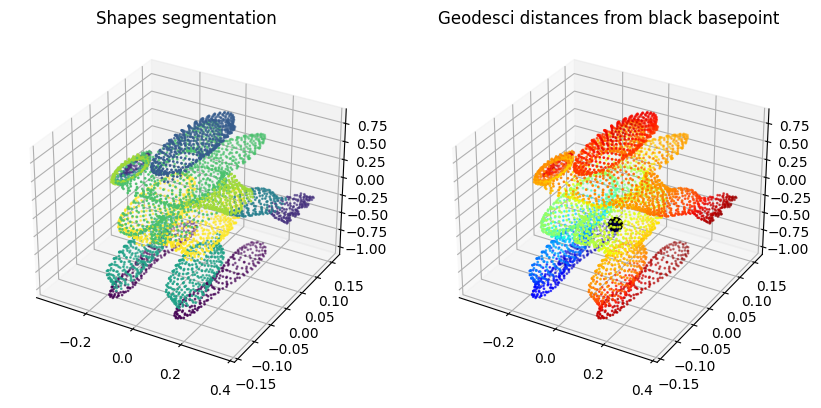

In [8]:
dataset_path = './shapes1/LabeledDB_new/'
vertices1, faces1 = off2numpy(dataset_path + 'Human/1.off')
label_faces1 = get_labels(dataset_path + 'Human/1_labels.txt', len(faces1))
labels = skp.LabelEncoder().fit_transform(face2points(label_faces1, faces1, len(vertices1)))
basepoint1 = 166
print_figure_labels_distances(basepoint1, vertices1, faces1, label_faces1)

At left, we can see the shape with the different parts from the label file. At right, we can see the geodesic distances from the basepoint (ball in black in the left feet). We can see that the distances are well computed. The interest is that we respect the shape of the body. For example, with the Euclidean distance, the two foot will be very close. Here, there are far one from each other because we need to go up and down in the other leg.

# 3. Point signatures <a class="anchor" id="chapter3"></a>

In [9]:
def get_simplex_tree_from_faces(faces):
    '''
    we create a simplex tree from faces, to then assign the geodesic distances as filtration
    '''  
    simplex_tree = gudhi.SimplexTree()
    for face in faces:
        simplex_tree.insert(face, -1e10)
    return simplex_tree

In [10]:
def compute_point_signatures(vertices, faces, basepoints):
    """Compute point signatures on a 3D shape using geodesic distances."""
    dgms = []
    graph = create_mesh_graph(vertices, faces)
    for basepoint in basepoints:
        st = get_simplex_tree_from_faces(faces)
        distances = approx_geodesic_distances(graph, basepoint)
        for vertex in range(len(vertices)):
            st.assign_filtration([vertex], filtration = -distances[vertex])
        st.make_filtration_non_decreasing()
        st.persistence()
        dgms.append(st.persistence_intervals_in_dimension(0)) 
    return dgms

Note: we study here the persitence diagram in homology dimension 0.

# 4. Stability theorem <a class="anchor" id="chapter4"></a>

We print the persistent diagrams as scatter plots, because the gudhi function gudhi.plot_persistence_diagram(persistence) doesn't work well neither on jupyter/colab notebook nor locally on vscode.

In [11]:
def print_two_PD(vertices1, faces1, basepoint1, vertices2, faces2, basepoint2):
    '''
    print the two PD side by side to compare them
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.suptitle('Persistent Diagrams')
    fig.set_size_inches(10, 5)
    ax1.set_xlabel('birth')
    ax1.set_ylabel('death')
    ax2.set_xlabel('birth')
    ax2.set_ylabel('death')
    basepoints1 = [basepoint1]
    signatures = compute_point_signatures(vertices1, faces1, basepoints1)
    for signature in signatures:
        for point in signature:
            point = list(point)
            ax1.scatter(point[0], point[1])
    basepoints2 = [basepoint2]
    signatures = compute_point_signatures(vertices2, faces2, basepoints2)
    for signature in signatures:
        for point in signature:
            point = list(point)
            ax2.scatter(point[0], point[1])
    plt.show()

## 4.1 Stability between two shapes <a class="anchor" id="section_4_1"></a>

In [12]:
vertices2, faces2 = off2numpy(dataset_path + 'Human/2.off')
label_faces2 = get_labels(dataset_path + 'Human/2_labels.txt', len(faces2))
basepoint2 = 0

First, we can check that the two basepoints are at the same place for the two shapes. As seen in the previous section, the first basepoint is on the left feet of the body. Let's see the figure for the second shape:

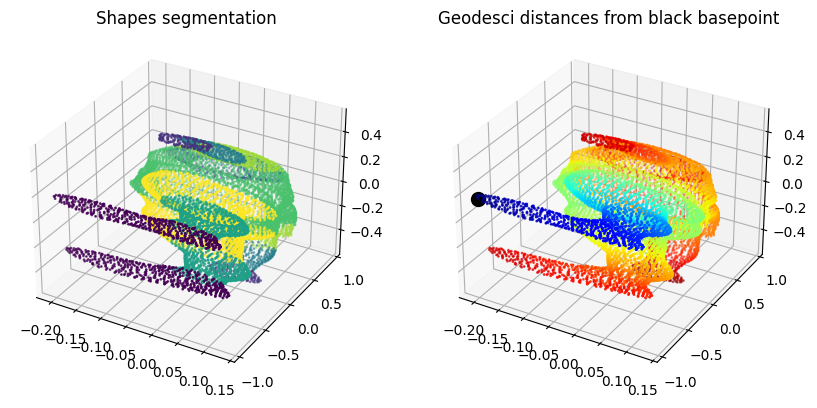

In [13]:
print_figure_labels_distances(basepoint2, vertices2, faces2, label_faces2)

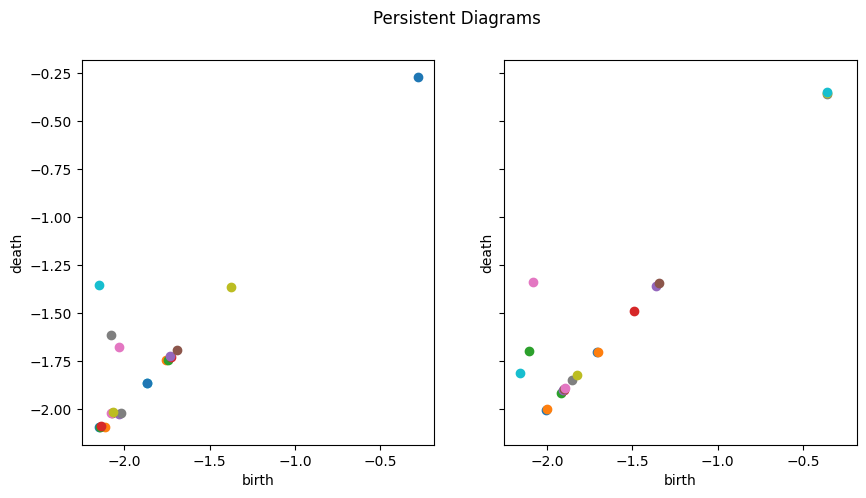

In [14]:
print_two_PD(vertices1, faces1, basepoint1, vertices2, faces2, basepoint2)

We see here that for the two shapes, the persistence diagram are very close: the stability therorem is verified!

## 4.2 Stability for two close basepoints <a class="anchor" id="section_4_2"></a>

Let's check the stability theorem for two close points on the same figure. To begin with, we will check that we select an other basepoint close to basepoint1:

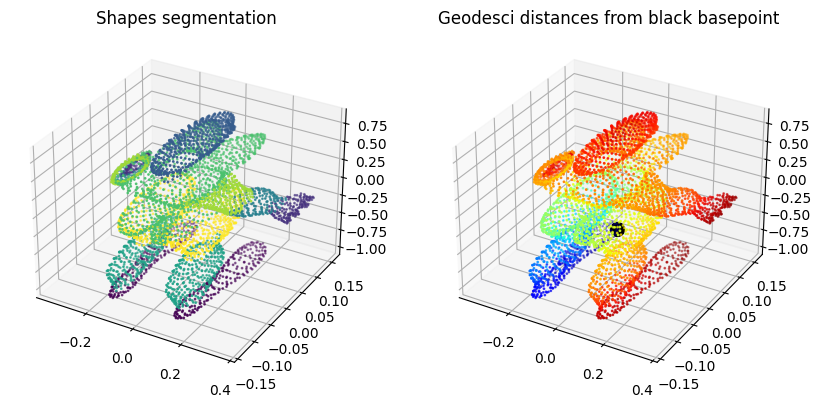

In [15]:
basepoint1_2 = 282
print_figure_labels_distances(basepoint1_2, vertices1, faces1, label_faces1)

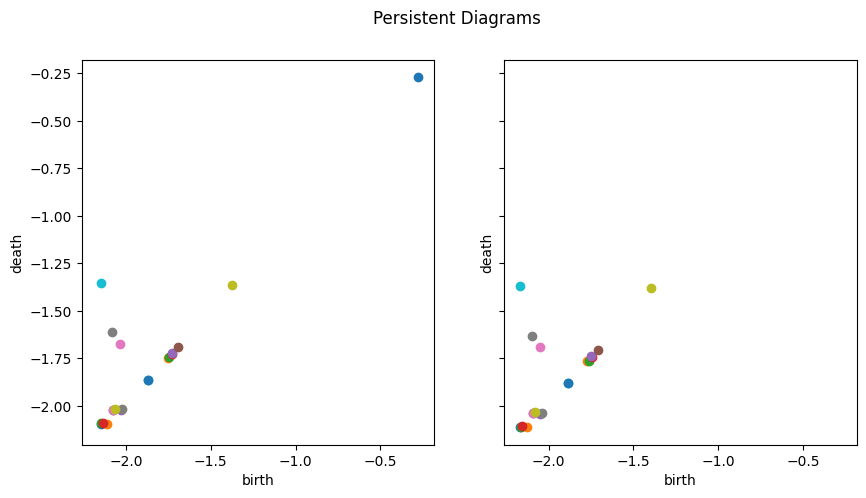

In [16]:
print_two_PD(vertices1, faces1, basepoint1, vertices1, faces1, basepoint1_2)

Again, we can see that the persistent diagrams are very close. This method seems therefore very interesting the compute shape segmentation or shape classification.

# 5. Statistical tests <a class="anchor" id="chapter5"></a>

We will compare if two diagrams represent the same objects. To do this, we will use Maximum Mean Discrepancy (MMD) on two diagrams with permutation test and use p-value as statistical discriminator.

In [17]:
# Define function to compute MMD statistics
def compute_mmd(S1, S2):
    n1 = len(S1)
    n2 = len(S2)
    V = gdr.Landscape()
    Dfx = lambda x: x
    Dfy = lambda y: y
    MMD = np.linalg.norm((1/n1)*sum(V(Dfx(diagram)) for diagram in S1) - (1/n2)*sum(V(Dfy(diagram)) for diagram in S2))
    return MMD


def permutation_test(S1, S2, MMD_obs, n_permutations=1000):
    n1 = len(S1)
    n2 = len(S2)
    MMD_perm = np.zeros(n_permutations)
    S = np.concatenate(np.array([S1, S2], dtype='object'))
    for i in range(n_permutations):
        np.random.shuffle(S)
        S1_perm = S[:n1]
        S2_perm = S[n1:]
        MMD_perm[i] = compute_mmd(S1_perm, S2_perm)
    p_value = (sum(MMD_perm > MMD_obs) + 1)/(n_permutations + 1)
    return p_value

# Perform permutation test on example persistence diagrams
# p_value = permutation_test(ds3, ds4)

def test_mmd(diag1, diag2):
    MMD_obs = compute_mmd(diag1, diag2)
    p_value = permutation_test(diag1, diag2, MMD_obs)
    # Print results
    print('Observed MMD statistic: %.4f' % MMD_obs)
    print('Permutation test p-value: %.4f' % p_value)
    if p_value < 0.05:
        print(colored('Reject null hypothesis - persistence diagrams are different', 'red'))
    else:
        print(colored('Cannot reject null hypothesis - persistence diagrams are similar', 'green'))


In [18]:
# Generate example persistence diagrams for two shapes

human_labels = np.random.choice(np.arange(1, 9), 2, replace=False)
ant_labels = np.random.choice(np.arange(81, 101), 2, replace=False)

human_diagrams = []
ant_diagrams = []

for hl in human_labels:
    vertices, faces = off2numpy(dataset_path + f'Human/{hl}.off')
    label_faces = get_labels(dataset_path + f'Human/{hl}_labels.txt', len(faces))
    basepoints = np.arange(0,len(vertices),len(vertices)//10)
    diagrams_shape = compute_point_signatures(vertices, faces, basepoints)
    human_diagrams.append(gdr.DiagramSelector(point_type='finite', use=True).fit_transform(diagrams_shape))

for hl in ant_labels:
    vertices, faces = off2numpy(dataset_path + f'ant/{hl}.off')
    label_faces = get_labels(dataset_path + f'ant/{hl}_labels.txt', len(faces))
    basepoints = np.arange(0,len(vertices),len(vertices)//10)
    diagrams_shape = compute_point_signatures(vertices, faces, basepoints)
    ant_diagrams.append(gdr.DiagramSelector(point_type='finite', use=True).fit_transform(diagrams_shape))




In [19]:
print(colored('Checking if human diagrams are', 'yellow'), colored('similar', 'green'))
for hd1 in human_diagrams:
    for hd2 in human_diagrams:
        print('')
        test_mmd(hd1, hd2)

print('')
print(colored('Checking if ant diagrams are', 'yellow'), colored('similar', 'green'))
for hd1 in ant_diagrams:
    for hd2 in ant_diagrams:
        print('')
        test_mmd(hd1, hd2)

print('')
print(colored('Checking if human and ant diagrams are', 'yellow'), colored('different', 'red'))
for hd1 in human_diagrams:
    for hd2 in ant_diagrams:
        print('')
        test_mmd(hd1, hd2)

Checking if human diagrams are similar

Observed MMD statistic: 0.0000
Permutation test p-value: 1.0000
Cannot reject null hypothesis - persistence diagrams are similar

Observed MMD statistic: 0.5305
Permutation test p-value: 0.6623
Cannot reject null hypothesis - persistence diagrams are similar

Observed MMD statistic: 0.5305
Permutation test p-value: 0.6563
Cannot reject null hypothesis - persistence diagrams are similar

Observed MMD statistic: 0.0000
Permutation test p-value: 1.0000
Cannot reject null hypothesis - persistence diagrams are similar

Checking if ant diagrams are similar

Observed MMD statistic: 0.0000
Permutation test p-value: 1.0000
Cannot reject null hypothesis - persistence diagrams are similar

Observed MMD statistic: 1.0627
Permutation test p-value: 0.1489
Cannot reject null hypothesis - persistence diagrams are similar

Observed MMD statistic: 1.0627
Permutation test p-value: 0.1718
Cannot reject null hypothesis - persistence diagrams are similar

Observed MMD

We can see that our algorithm manages to differenciate diagrams from human and ant shapes.

# 6. Segmentation problem <a class="anchor" id="chapter6"></a>

Now, let's use our persistent diagrams to compute shapes segmentation. We will see if we are able to recognize the different part of a shape. For that, we use different vectorization methods (persistent landscapes or images) and train different models  (randomForest, kNN) with different hyperparameters. We compute cross validation to choose the best model with the best hyperparameters, and test it on a test set.

In [20]:
# Generate dataset of persistence diagrams for the human category
basepoints_all = np.arange(len(vertices1))
print('Compute points signatures...')
dgms = compute_point_signatures(vertices1, faces1, basepoints_all)

Compute points signatures...


In [21]:
np.random.seed(0)
test_size            = 0.95
perm                 = np.random.permutation(len(labels))
limit                = int(test_size * len(labels))
test_sub, train_sub  = perm[:limit], perm[limit:]
train_labs           = np.array(labels)[train_sub]
test_labs            = np.array(labels)[test_sub]
train_dgms           = [dgms[i] for i in train_sub]
test_dgms            = [dgms[i] for i in test_sub]

In [22]:
pipe = skl.Pipeline([("Separator", gdr.DiagramSelector(limit=np.inf, point_type="finite")),
                     ("Scaler",    gdr.DiagramScaler(scalers=[([0,1], skp.MinMaxScaler())])),
                     ("TDA",       gdr.PersistenceImage()),
                     ("Estimator", sks.SVC())])

param =    [{"Separator__use":      [True],
             "Scaler__use":         [False, True],
             "TDA":                 [gdr.Silhouette()], 
             "TDA__resolution":     [100],
             "Estimator":           [ske.RandomForestClassifier()]},
           
            {"Separator__use":      [True],
             "Scaler__use":         [False, True],
             "TDA":                 [gdr.BottleneckDistance()], 
             "TDA__epsilon":        [0.1], 
             "Estimator":           [skn.KNeighborsClassifier(metric="precomputed")]}
           ]

In [23]:
print('GridSearch...')
model = skm.GridSearchCV(pipe, param, cv=3)
print('Training...')
model = model.fit(train_dgms, train_labs)
print(model.best_params_)
print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

GridSearch...
Training...
{'Estimator': RandomForestClassifier(), 'Scaler__use': True, 'Separator__use': True, 'TDA': Silhouette(), 'TDA__resolution': 100}
Train accuracy = 1.0
Test accuracy  = 0.9228187919463087


We see that we achieve very impressionant results, with an accuracy of about $92\%$. Therefore, this method works well to achieve shape segmentation!